In [1]:
from mpmath.tests.runtests import coverage
%load_ext autoreload
%autoreload 2

from typing import List, Optional
from omegaconf import OmegaConf
import os
import time
import json
import wandb
import logging
import argparse

import torch
import numpy as np
from datasets.driving_dataset import DrivingDataset
from datasets.my_dataset import MyDataset
from utils.misc import import_str
from models.trainers import BasicTrainer
from models.video_utils import (
    render_images,
    save_videos,
    render_novel_views
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cfg = OmegaConf.load(os.path.join("/mnt/e/Output/cam5/149", "config.yaml"))
%cd /home/a/drivestudio

dataset = MyDataset(cfg.data)

/home/a/drivestudio


Loading images:   4%|▍         | 8/199 [00:00<00:05, 36.74it/s]

undistorting rgb


Loading dynamic masks:   3%|▎         | 6/199 [00:00<00:03, 57.63it/s]

undistorting dynamic mask


Loading human masks:   3%|▎         | 6/199 [00:00<00:03, 51.81it/s]

undistorting human mask


Loading vehicle masks:   4%|▍         | 8/199 [00:00<00:02, 71.48it/s]

undistorting vehicle mask


Loading sky masks:  10%|█         | 20/199 [00:00<00:01, 96.94it/s]

undistorting sky mask


Loading images:   3%|▎         | 5/199 [00:00<00:04, 42.20it/s]

undistorting rgb


Loading dynamic masks:   4%|▍         | 8/199 [00:00<00:02, 70.15it/s]

undistorting dynamic mask


Loading human masks:   7%|▋         | 14/199 [00:00<00:02, 68.96it/s]

undistorting human mask


Loading vehicle masks:   8%|▊         | 16/199 [00:00<00:02, 78.90it/s]

undistorting vehicle mask


Loading sky masks:   5%|▌         | 10/199 [00:00<00:02, 94.17it/s]

undistorting sky mask


Loading images:   4%|▍         | 8/199 [00:00<00:05, 37.11it/s]

undistorting rgb


Loading dynamic masks:   7%|▋         | 14/199 [00:00<00:02, 69.26it/s]

undistorting dynamic mask


Loading human masks:   7%|▋         | 14/199 [00:00<00:02, 66.33it/s]

undistorting human mask


Loading vehicle masks:   8%|▊         | 16/199 [00:00<00:02, 77.38it/s]

undistorting vehicle mask


Loading sky masks:  11%|█         | 22/199 [00:00<00:01, 106.66it/s]

undistorting sky mask


Loading images:   5%|▌         | 10/199 [00:00<00:04, 46.24it/s]

undistorting rgb


Loading dynamic masks:   5%|▍         | 9/199 [00:00<00:02, 83.31it/s]

undistorting dynamic mask


Loading human masks:   5%|▍         | 9/199 [00:00<00:02, 82.46it/s]

undistorting human mask


Loading vehicle masks:   4%|▍         | 8/199 [00:00<00:02, 72.50it/s]

undistorting vehicle mask


Loading sky masks:  12%|█▏        | 24/199 [00:00<00:01, 118.99it/s]

undistorting sky mask


Loading images:   3%|▎         | 5/199 [00:00<00:04, 44.52it/s]

undistorting rgb


Loading dynamic masks:   5%|▍         | 9/199 [00:00<00:02, 87.50it/s]

undistorting dynamic mask


Loading human masks:   9%|▉         | 18/199 [00:00<00:02, 85.59it/s]

undistorting human mask


Loading vehicle masks:   5%|▌         | 10/199 [00:00<00:02, 93.26it/s]

undistorting vehicle mask


Loading sky masks:  11%|█         | 22/199 [00:00<00:01, 109.01it/s]

undistorting sky mask


Loading lidar:   0%|          | 0/199 [00:00<?, ?it/s]/home/a/drivestudio/datasets/waymo/waymo_sourceloader.py:411: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  lidar_origins = torch.from_numpy(lidar_info[:, :3]).float()  # 提取原点
Loading lidar: 100%|██████████| 199/199 [00:25<00:00,  7.92it/s]
Projecting lidar pts on images for camera front_camera: 100%|██████████| 199/199 [00:05<00:00, 33.21it/s]
Projecting lidar pts on images for camera front_left_camera: 100%|██████████| 199/199 [00:07<00:00, 25.83it/s]
Projecting lidar pts on images for camera front_right_camera: 100%|██████████| 199/199 [00:06<00:00, 32.86it/s]
Proje

In [3]:
source = dataset.lidar_source
points = source.origins + source.directions * source.ranges
grounds = source.grounds
flow_class = source.flow_classes
points.shape, grounds.shape, flow_class.shape

(torch.Size([19016548, 3]), torch.Size([19016548]), torch.Size([19016548]))

In [ ]:
import matplotlib.pyplot as plt

def plot_lidar_points(lidar_points, ground_mask=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(lidar_points[:, 0][~ground_mask], lidar_points[:, 1][~ground_mask], c='b', s=1)  # 2D scatter plot
    plt.title('2D Lidar Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_lidar_points(points.numpy(), grounds.numpy())  # Convert to numpy array for plotting


In [ ]:
import torch.nn.functional as F

def create_voxel_grid_2d(lidar_points, voxel_size=1):
    z = lidar_points[:, 2]
    lidar_points = lidar_points[(-1 <= z) & (z <= 3)]
    x_min, x_max = lidar_points[:, 0].min(), lidar_points[:, 0].max()
    y_min, y_max = lidar_points[:, 1].min(), lidar_points[:, 1].max()
    
    grid_size_x = int((x_max - x_min) / voxel_size) + 1
    grid_size_y = int((y_max - y_min) / voxel_size) + 1
    
    voxel_grid = torch.zeros((grid_size_x, grid_size_y), dtype=torch.int32)
    
    # 计算每个点的体素索引
    voxel_indices_x = ((lidar_points[:, 0] - x_min) / voxel_size).long()
    voxel_indices_y = ((lidar_points[:, 1] - y_min) / voxel_size).long()
    
    # 将二维索引展平成一维索引
    flat_indices = voxel_indices_x * grid_size_y + voxel_indices_y
    
    # 使用 torch.bincount 统计每个体素的点数量
    counts = torch.bincount(flat_indices, minlength=grid_size_x * grid_size_y)
    
    # 将一维结果重塑为二维网格
    voxel_grid = counts.view(grid_size_x, grid_size_y)
    
    return voxel_grid

p = points[~grounds]
c = flow_class[~grounds]

# 生成2D体素网格
voxel_grid_2d = create_voxel_grid_2d(p[c<=0])


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(voxel_grid_2d.numpy() > 3, cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()


In [4]:

cameras = dataset.pixel_source.camera_data
camera_0 = cameras[1]

poses = camera_0.cam_to_worlds
intrinsic = camera_0.intrinsics[0]
fov = 2 * torch.atan2(intrinsic[0, 2], intrinsic[0, 0])  # 计算视场角 (FOV)

import math

pose = poses[1]     # 4x4
cx = pose[0, 3]
cy = pose[1, 3]
angle = math.atan2(pose[1, 0], pose[0, 0])
cameras

{0: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7efc0c4d17c0>,
 1: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7efc0c4d98b0>,
 2: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7efc44313220>,
 3: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7efc0c4d9700>,
 4: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7efc0c4abf10>}

In [5]:
from utils.mytools import Camera, Grid2d, CameraSet, Grid2dNumba
grid = Grid2d(points, grounds, flow_class, cameras)




In [6]:
grid_numba = Grid2dNumba(grid, radius=8)

In [7]:
area_coverage = grid_numba.get_area_coverage()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float32, 2d, C), array(bool, 2d, C))
 
There are 22 candidate implementations:
  - Of which 20 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float32, 2d, C), array(bool, 2d, C))':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 211.
    With argument(s): '(array(float32, 2d, C), array(bool, 2d, C))':
   Rejected as the implementation raised a specific error:
     NumbaTypeError: Multi-dimensional indices are not supported.
  raised from /home/a/anaconda3/envs/drivestudio/lib/python3.9/site-packages/numba/core/typing/arraydecl.py:91

During: typing of intrinsic-call at /home/a/drivestudio/utils/mytools.py (161)

File "utils/mytools.py", line 161:
def compute_voxel_coverage(ang, voxel_hit_angles, sigma=np.pi/180):
    <source elided>
    # 去除 nan
    voxel_hit_angles = voxel_hit_angles[~np.isnan(voxel_hit_angles)]
    ^

During: resolving callee type: type(CPUDispatcher(<function compute_voxel_coverage at 0x7efc0c445940>))
During: typing of call at /home/a/drivestudio/utils/mytools.py (151)

During: resolving callee type: type(CPUDispatcher(<function compute_voxel_coverage at 0x7efc0c445940>))
During: typing of call at /home/a/drivestudio/utils/mytools.py (151)


File "utils/mytools.py", line 151:
def compute_area_coverage(voxel_indices, voxel_hit_angles, coord_range, grid_range, area_indices, fov, grid_size, num_rays=100, max_distance=50):
    <source elided>
                else:
                    voxel_coverage = compute_voxel_coverage(ang, voxel_hit_angles=voxel_hit_angles[voxel_index])
                    ^


In [168]:
grid_numba.grid_size.numpy()

AttributeError: 'float' object has no attribute 'numpy'

In [ ]:
map = grid.get_hot_map()

map.shape, grid.voxel_grid_2d.shape

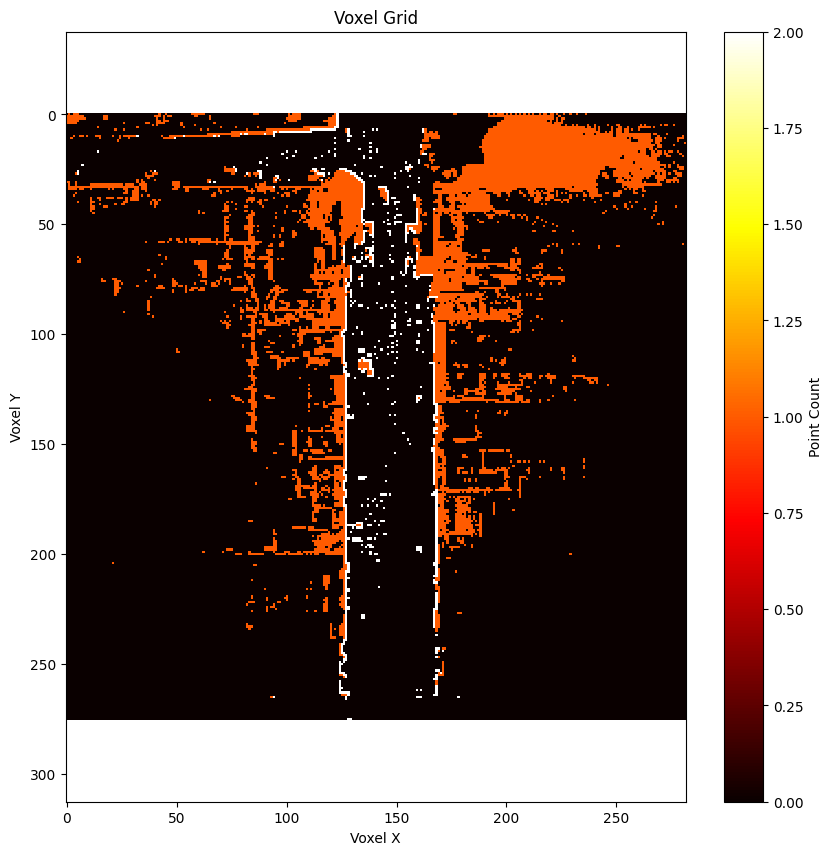

In [78]:
plt.figure(figsize=(10, 10))
plt.imshow(map.numpy(), cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()

In [87]:
coverages = []
for cam in cameras.values():
    print(cam)
    coverages.append(grid.get_camera_set_coverage(CameraSet(cam.cam_to_worlds, cam.intrinsics)))
print(coverages)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1

In [85]:
camera = Camera(pose, intrinsic)
grid.get_camera_coverage(camera)

1.0